<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/GIN_Individual_Elephant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyzing socializing pattern of Elephant using GIN model, here analyzed socialing pattern of an individual Elephant

In [ ]:
!pip install torch-geometric

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GINConv, Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
# Load and preprocess data
data = pd.read_csv('Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index", "Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

# Filter data for one elephant
specific_tag = 5748  # Change the index to select a different elephant
data = data[data['Tag'] == specific_tag].copy()

# Calculate time differences in seconds
data.loc[:, 'Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)

# Calculate latitude and longitude differences
data.loc[:, 'Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data.loc[:, 'Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)

# Handle small or zero time differences to avoid infinite speeds
data.loc[:, 'Time_diff'] = data['Time_diff'].replace(0, np.nan).fillna(method='bfill').fillna(1)

# Calculate speed in degrees per second
data.loc[:, 'Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / data['Time_diff']

# Replace infinities and NaNs with zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

# Convert speed to meters per second
degree_to_meters = 111320  # meters per degree at the equator
data.loc[:, 'Speed_mps'] = data['Speed'] * degree_to_meters


In [ ]:
# Normalize features
scaler = MinMaxScaler()
features = scaler.fit_transform(data[['Latitude', 'Longitude', 'Speed_mps']])
# Create edges for the graph using sequential indices
edges = []
indices = data.index.tolist()
for i in range(len(indices) - 1):
    edges.append([i, i + 1])

# Create graph data object
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(data[['Latitude', 'Longitude', 'Speed_mps']].values, dtype=torch.float)


In [ ]:
# Graph data object
graph_data = Data(x=x, edge_index=edge_index, y=y)
num_nodes = x.size(0)
train_indices, val_indices = train_test_split(np.arange(num_nodes), test_size=0.2, random_state=42)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
val_mask[val_indices] = True
graph_data.train_mask = train_mask
graph_data.val_mask = val_mask

# Create data loaders
train_loader = DataLoader([graph_data], batch_size=32, shuffle=True)
val_loader = DataLoader([graph_data], batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Define the GIN model
class GIN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.gin = Sequential('x, edge_index', [
            (GINConv(torch.nn.Linear(num_features, hidden_dim), train_eps=True), 'x, edge_index -> x'),
            torch.nn.ReLU(inplace=True),
            (GINConv(torch.nn.Linear(hidden_dim, hidden_dim), train_eps=True), 'x, edge_index -> x'),
            torch.nn.ReLU(inplace=True)
        ])
        self.regressor = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gin(x, edge_index)
        x = self.regressor(x)
        return x

# Initialize the model
model = GIN(num_features=3, hidden_dim=256, output_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction='mean')

Epoch 1: Train Loss: 417.0339, Val Loss: 285.7240, Train RMSE: 20.4214, Val RMSE: 16.9034
Epoch 2: Train Loss: 285.5736, Val Loss: 147.1671, Train RMSE: 16.8989, Val RMSE: 12.1312
Epoch 3: Train Loss: 146.8308, Val Loss: 30.3194, Train RMSE: 12.1174, Val RMSE: 5.5063
Epoch 4: Train Loss: 29.8050, Val Loss: 49.5972, Train RMSE: 5.4594, Val RMSE: 7.0425
Epoch 5: Train Loss: 49.0580, Val Loss: 101.2025, Train RMSE: 7.0041, Val RMSE: 10.0599
Epoch 6: Train Loss: 100.7457, Val Loss: 67.8773, Train RMSE: 10.0372, Val RMSE: 8.2388
Epoch 7: Train Loss: 67.4209, Val Loss: 24.6610, Train RMSE: 8.2110, Val RMSE: 4.9660
Epoch 8: Train Loss: 24.1846, Val Loss: 12.1893, Train RMSE: 4.9178, Val RMSE: 3.4913
Epoch 9: Train Loss: 11.7232, Val Loss: 23.5616, Train RMSE: 3.4239, Val RMSE: 4.8540
Epoch 10: Train Loss: 23.1328, Val Loss: 38.9595, Train RMSE: 4.8097, Val RMSE: 6.2418
Epoch 11: Train Loss: 38.5738, Val Loss: 46.6107, Train RMSE: 6.2108, Val RMSE: 6.8272
Epoch 12: Train Loss: 46.2625, Val Los

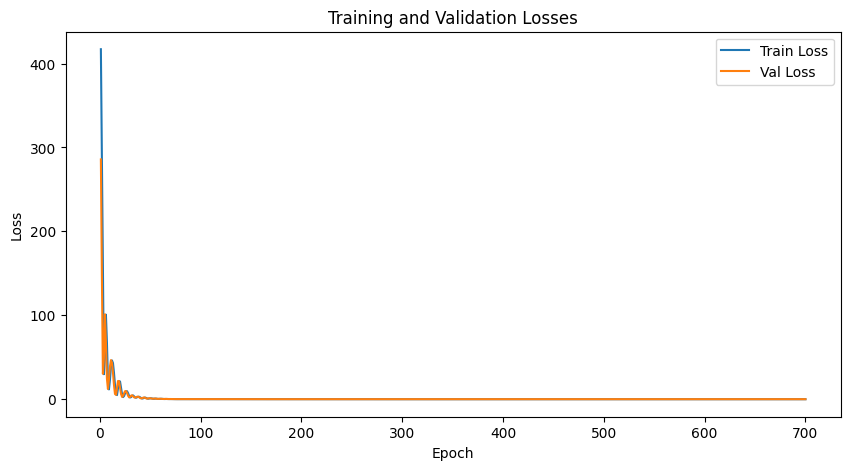

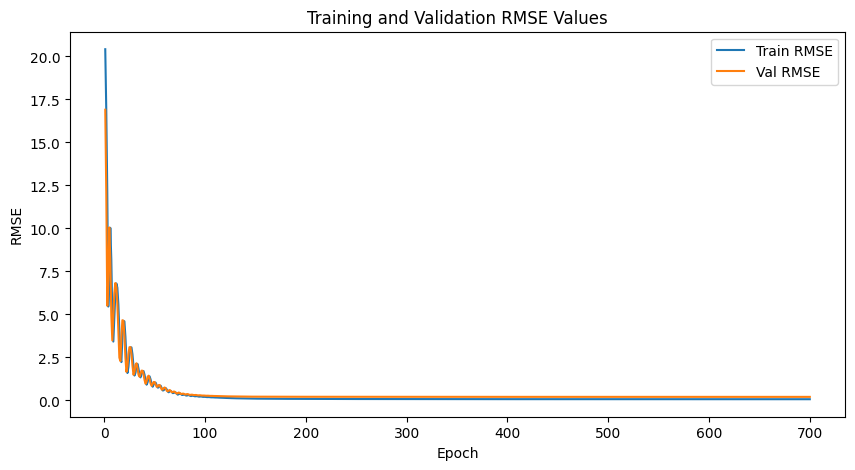

In [ ]:
import torch.nn as nn

# Train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    train_rmse_values = []
    val_rmse_values = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        total_train_rmse = 0

        for data in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * data.num_graphs

            # Calculate RMSE
            rmse = torch.sqrt(nn.functional.mse_loss(output[data.train_mask], data.y[data.train_mask]))
            total_train_rmse += rmse.item() * data.num_graphs

        model.eval()
        total_val_loss = 0
        total_val_rmse = 0

        with torch.no_grad():
            for data in val_loader:
                output = model(data)
                loss = criterion(output[data.val_mask], data.y[data.val_mask])
                total_val_loss += loss.item() * data.num_graphs

                # Calculate RMSE
                rmse = torch.sqrt(nn.functional.mse_loss(output[data.val_mask], data.y[data.val_mask]))
                total_val_rmse += rmse.item() * data.num_graphs

        # Average losses and RMSE over all batches
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        avg_train_rmse = total_train_rmse / len(train_loader.dataset)
        avg_val_rmse = total_val_rmse / len(val_loader.dataset)

        # Record losses and RMSE values
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_rmse_values.append(avg_train_rmse)
        val_rmse_values.append(avg_val_rmse)

        print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}')

    # Plotting training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Plotting training and validation RMSE values
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_rmse_values, label='Train RMSE')
    plt.plot(range(1, epochs + 1), val_rmse_values, label='Val RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE Values')
    plt.legend()
    plt.show()

# Train and validate the model
train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, 700)


In [ ]:
# Save the model
torch.save(model.state_dict(), 'gin_model_individualElephant.pt')

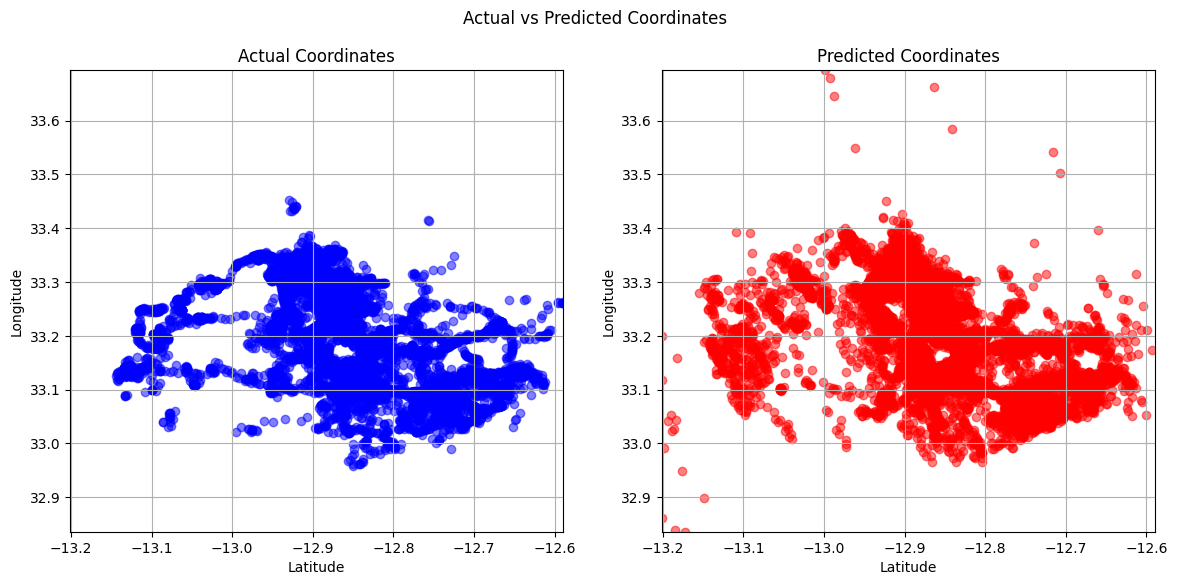

Average Evaluation Loss: 0.0129
Root Mean Square Error (RMSE): 0.1136


In [ ]:
# Load and evaluate the model
from sklearn.metrics import mean_squared_error
model.load_state_dict(torch.load('gin_model_individualElephant.pt'))
model.eval()

def evaluate_model(test_loader, model):
    actuals = []
    predictions = []
    total_loss = 0
    criterion = torch.nn.MSELoss()  # Assuming MSE loss for evaluation
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            actuals.append(data.y.cpu().numpy())
            predictions.append(output.cpu().numpy())
    actuals = np.vstack(actuals)
    predictions = np.vstack(predictions)
    avg_loss = total_loss / len(test_loader)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return actuals, predictions, avg_loss, rmse

# Evaluate the model
actuals, predictions, avg_loss, rmse = evaluate_model(val_loader, model)

def remove_outliers(data, z_threshold=3):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    z_scores = (data - mean) / std_dev
    filtered_data = data[np.all(np.abs(z_scores) < z_threshold, axis=1)]
    return filtered_data

# Visualize Actual vs. Predicted Coordinates
def visualize_results_side_by_side(actuals, predictions):
    actuals_clean = remove_outliers(actuals)
    predictions_clean = remove_outliers(predictions)

    min_lat = min(actuals_clean[:, 0].min(), predictions_clean[:, 0].min())
    max_lat = max(actuals_clean[:, 0].max(), predictions_clean[:, 0].max())
    min_lon = min(actuals_clean[:, 1].min(), predictions_clean[:, 1].min())
    max_lon = max(actuals_clean[:, 1].max(), predictions_clean[:, 1].max())

    # Plot actual coordinates
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(actuals_clean[:, 0], actuals_clean[:, 1], color='blue', alpha=0.5)
    plt.title('Actual Coordinates')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.grid(True)
    plt.xlim(min_lat, max_lat)
    plt.ylim(min_lon, max_lon)

    # Plot predicted coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(predictions_clean[:, 0], predictions_clean[:, 1], color='red', alpha=0.5)
    plt.title('Predicted Coordinates')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.grid(True)
    plt.xlim(min_lat, max_lat)
    plt.ylim(min_lon, max_lon)

    plt.suptitle('Actual vs Predicted Coordinates')
    plt.show()

    print(f"Average Evaluation Loss: {avg_loss:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

visualize_results_side_by_side(actuals, predictions)


In [ ]:
!pip install geopandas contextily


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 70.5 MB/s eta 0:00:00


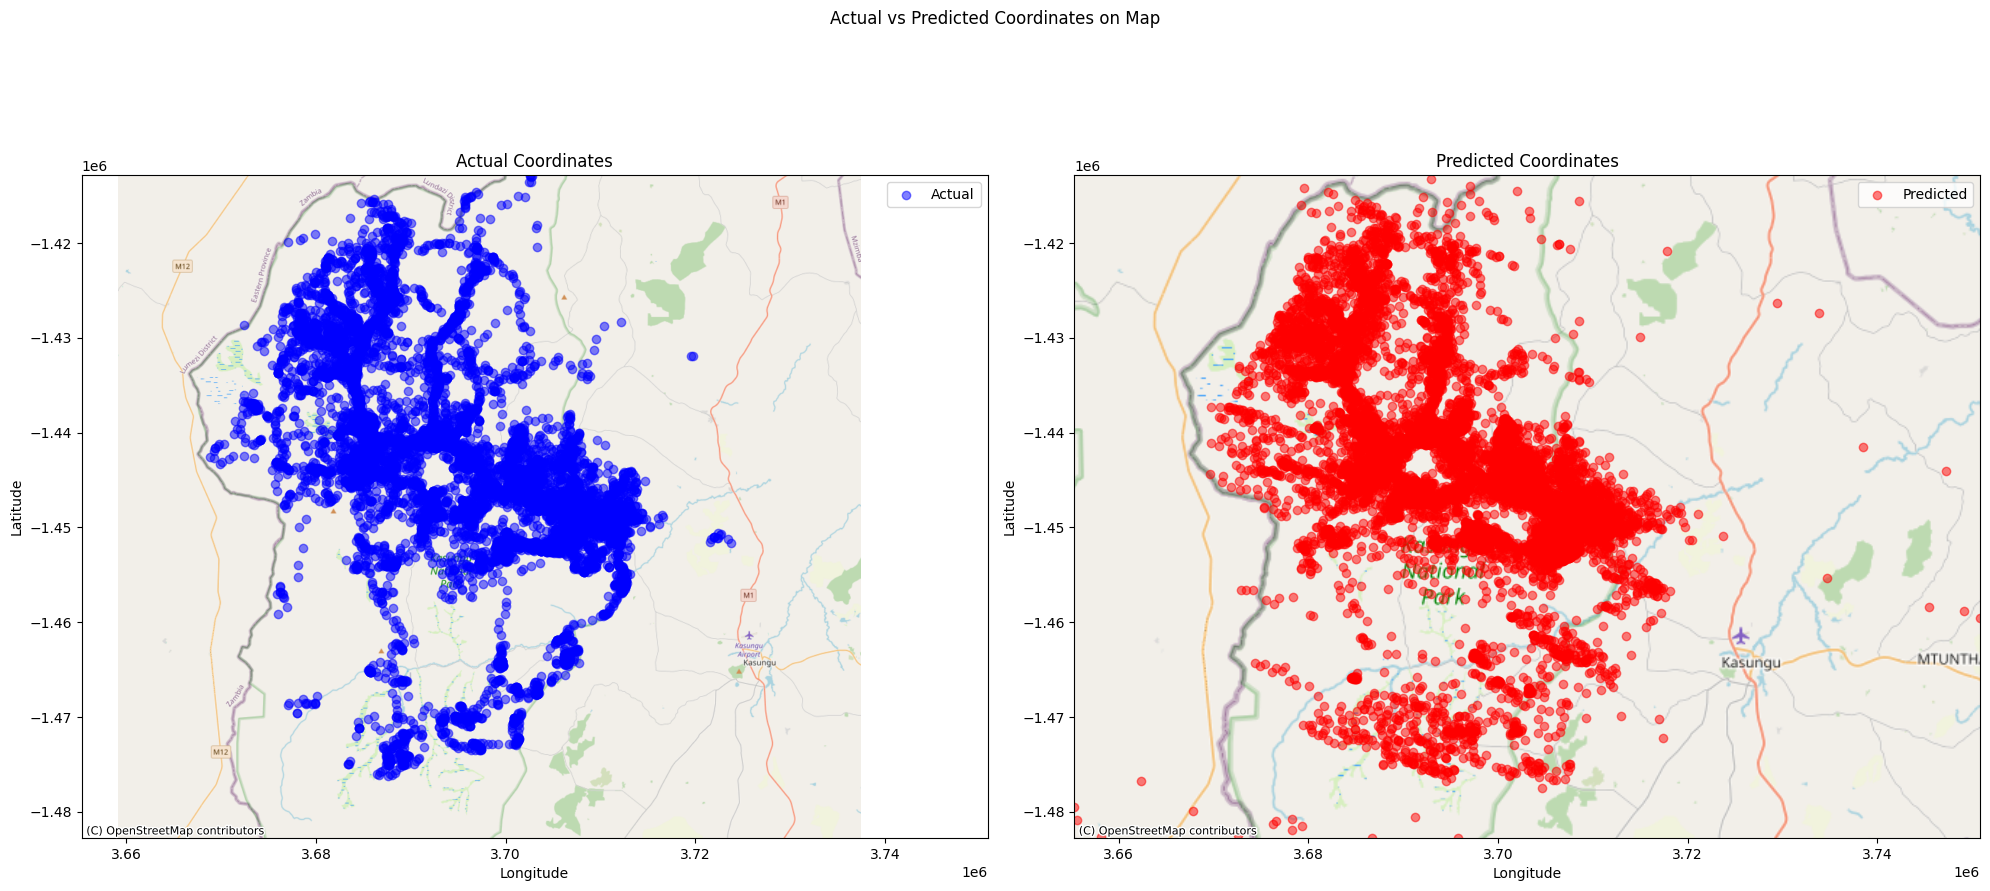

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# Load and evaluate the model
model.load_state_dict(torch.load('gin_model_individualElephant.pt'))
model.eval()

def evaluate_model(test_loader, model):
    actuals = []
    predictions = []
    total_loss = 0
    criterion = torch.nn.MSELoss()  # Assuming MSE loss for evaluation
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            actuals.append(data.y.cpu().numpy())
            predictions.append(output.cpu().numpy())
    actuals = np.vstack(actuals)
    predictions = np.vstack(predictions)
    avg_loss = total_loss / len(test_loader)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return actuals, predictions, avg_loss, rmse

actuals, predictions, avg_loss, rmse = evaluate_model(val_loader, model)

def remove_outliers(data, z_threshold=3):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    z_scores = (data - mean) / std_dev
    filtered_data = data[np.all(np.abs(z_scores) < z_threshold, axis=1)]
    return filtered_data

# Function to convert coordinates to GeoDataFrame
def to_geodataframe(coords, crs="EPSG:4326"):
    geometry = [Point(xy) for xy in zip(coords[:, 1], coords[:, 0])]
    return gpd.GeoDataFrame(geometry=geometry, crs=crs)

# Function to plot actual vs. predicted coordinates on a map
def plot_actual_vs_predicted_on_map(actuals, predictions):
    actuals_clean = remove_outliers(actuals)
    predictions_clean = remove_outliers(predictions)

    # Create GeoDataFrames
    gdf_actuals = to_geodataframe(actuals_clean)
    gdf_predictions = to_geodataframe(predictions_clean)

    # Convert GeoDataFrames to Web Mercator for contextily
    gdf_actuals = gdf_actuals.to_crs(epsg=3857)
    gdf_predictions = gdf_predictions.to_crs(epsg=3857)

    # Determine common axis limits
    min_lat = min(gdf_actuals.geometry.y.min(), gdf_predictions.geometry.y.min())
    max_lat = max(gdf_actuals.geometry.y.max(), gdf_predictions.geometry.y.max())
    min_lon = min(gdf_actuals.geometry.x.min(), gdf_predictions.geometry.x.min())
    max_lon = max(gdf_actuals.geometry.x.max(), gdf_predictions.geometry.x.max())

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot actual coordinates
    gdf_actuals.plot(ax=axes[0], marker='o', color='blue', alpha=0.5, label='Actual')
    ctx.add_basemap(axes[0], crs=gdf_actuals.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    axes[0].set_title('Actual Coordinates')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_xlim(min_lon, max_lon)
    axes[0].set_ylim(min_lat, max_lat)
    axes[0].legend()

    # Plot predicted coordinates
    gdf_predictions.plot(ax=axes[1], marker='o', color='red', alpha=0.5, label='Predicted')
    ctx.add_basemap(axes[1], crs=gdf_predictions.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    axes[1].set_title('Predicted Coordinates')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].set_xlim(min_lon, max_lon)
    axes[1].set_ylim(min_lat, max_lat)
    axes[1].legend()

    plt.suptitle('Actual vs Predicted Coordinates on Map')
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_actual_vs_predicted_on_map(actuals, predictions)
